# Clusteranalyse

Schritte zur Vorbereitung, später evtl. schon im Preprossessing erledigt:

Format
- Datumsspalte in Jahr, Monat, Tag trennen

Daten entfernen
- **Zeilen** aus 2014 und 2025 entfernen, weil zu wenige Datenpunkte
- **Spalten** mit zu vielen fehlenden Werten entfernen (cut-off: 53% missing values)
- Alle Einträge für **Tehran** entfernen, weil die Stadt durch ihre extrem hohen Schadstoffwerte die Clusteranalyse verzerrt

Aktuell auch noch relevant, aber im großen Datensatz vielleicht nicht mehr
- Bestimmen, in welchen der 95 Städte für **alle Schadstoffe** Messwerte vorliegen --> 54 Städte

Clusteranalyse
- StandardScaler und KMeans importieren
- Liste der Schadstoffe definieren (pollutants)
- gruppierten ("City") und reduzierten ("dropna") mit Mittelwerten ("mean") df nach Städten und Schadstoffen für als Datengrundlage der Clusteranalyse erstellen (**df_cluster**). df-cluster hat 53 Zeilen (Städte) und 6 Spalten (Schadstoffe)
- Daten skalieren (**df_cluster_scaled**)
- mit Ellbow-Methode optimale Clusteranzahl bestimmen --> 5 Cluster (Silhouette wurde auch getestet, brachte keinen Mehrwert)
- mit Kmeans Clusterzuordnung durchführen (**df_cluster_numbers**)

Output


In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

In [ ]:
# Settings for displaying floats
pd.set_option('display.float_format', '{:,.2f}'.format)

In [2]:
df = pd.read_csv("../data/cleaned_data_old.csv")
df.head()

,Year,Month,Day,Country,City,Latitude,Longitude,Population,Co,No2,...,Wind-speed,Dew,Humidity,Tavg,Tmin,Tmax,Prcp,Wdir,Wspd,Pres
0,2014,12,29,AT,Graz,47.06667,15.45000,269997.0,0.1,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014,12,29,AT,Innsbruck,47.26266,11.39454,124579.0,0.1,25.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,12,29,AT,Linz,48.30639,14.28611,193814.0,0.1,14.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,12,29,AT,Salzburg,47.79941,13.04399,146631.0,0.1,21.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,12,29,AT,Vienna,48.20849,16.37208,NaN,0.1,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.isna().sum()

Year                 0
Month                0
Day                  0
Country              0
City                 0
Latitude          2827
Longitude         2827
Population     1330384
Co              631350
No2             286040
O3              373831
Pm10            341643
Pm25            262612
Pressure        392601
So2             532580
Temperature     386303
Wind-gust       918398
Wind-speed      412176
Dew             694692
Humidity        388057
Tavg            290171
Tmin            315263
Tmax            317022
Prcp            652617
Wdir            522982
Wspd            453565
Pres            489606
dtype: int64

In [5]:
df.head()

,Year,Month,Day,Country,City,Latitude,Longitude,Population,Co,No2,...,Wind-speed,Dew,Humidity,Tavg,Tmin,Tmax,Prcp,Wdir,Wspd,Pres
0,2014,12,29,AT,Graz,47.06667,15.45000,269997.0,0.1,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014,12,29,AT,Innsbruck,47.26266,11.39454,124579.0,0.1,25.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,12,29,AT,Linz,48.30639,14.28611,193814.0,0.1,14.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,12,29,AT,Salzburg,47.79941,13.04399,146631.0,0.1,21.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,12,29,AT,Vienna,48.20849,16.37208,NaN,0.1,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Tehran komplett entfernen, weil die Schadstoffwerte zu sehr von allen übrigen Städten abweichen, was die Cluster verzerrt.
# Ashkelon komplett entfernen, weil der Wert für CO nur für Januar 2020 gemessen wurde und extrem von allen anderen Städte abweicht, was die Cluster verzerrt.
df = df[df["City"] != "Tehran"]
df = df[df["City"] != "Ashkelon"]


In [7]:
df['City'].nunique()

614

In [8]:
# Display the first 5 rows of the dataframe
df.head()

,Year,Month,Day,Country,City,Latitude,Longitude,Population,Co,No2,...,Wind-speed,Dew,Humidity,Tavg,Tmin,Tmax,Prcp,Wdir,Wspd,Pres
0,2014,12,29,AT,Graz,47.06667,15.45000,269997.0,0.1,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014,12,29,AT,Innsbruck,47.26266,11.39454,124579.0,0.1,25.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014,12,29,AT,Linz,48.30639,14.28611,193814.0,0.1,14.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,12,29,AT,Salzburg,47.79941,13.04399,146631.0,0.1,21.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014,12,29,AT,Vienna,48.20849,16.37208,NaN,0.1,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df.shape

(1688506, 27)

In [10]:
# Spalten mit zu vielen fehlenden Werten entfernen

# Berechnen, wie viele Prozent der Werte pro Spalte fehlen
missing_percent = df.isna().mean() * 100  

# Spalten auswählen, die weniger als 50% fehlende Werte haben
df_cleaned = df.loc[:, missing_percent <= 53]

# Ergebnis ausgeben
print(f"Anzahl der entfernten Spalten: {df.shape[1] - df_cleaned.shape[1]}")
print("Übrige Spalten:", df_cleaned.columns)


Anzahl der entfernten Spalten: 2
Übrige Spalten: Index(['Year', 'Month', 'Day', 'Country', 'City', 'Latitude', 'Longitude',
       'Co', 'No2', 'O3', 'Pm10', 'Pm25', 'Pressure', 'So2', 'Temperature',
       'Wind-speed', 'Dew', 'Humidity', 'Tavg', 'Tmin', 'Tmax', 'Prcp', 'Wdir',
       'Wspd', 'Pres'],
      dtype='object')


In [11]:
df_cleaned["City"].nunique()

614

## Code für Clusteranalyse (K-Means) zur Schadstoffbelastung

Input: df_cleaned

Output:

In [12]:
# Liste der Schadstoff-Features für das Clustering
pollutants = ["Co", "No2", "O3", "So2", "Pm10", "Pm25"]

In [13]:
# Clusteranalyse zur Schadstoffbelastung

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Durchschnittliche Schadstoffwerte pro Stadt berechnen
df_pollutants = df_cleaned.groupby("City")[pollutants].mean().dropna()

In [14]:
df_pollutants.head()

,Co,No2,O3,So2,Pm10,Pm25
City,,,,,,
Abu dhabi,0.100047,12.196341,27.721309,4.985944,79.439340,97.846117
Adana,4.047877,11.253878,16.466835,4.181442,31.489910,68.214783
Adapazarı,18.371643,12.695786,16.357013,19.657261,38.064474,72.090748
Adelaide,2.448863,20.026720,23.991919,8.578091,13.293801,16.636843
Aguascalientes,7.194328,16.041774,44.532891,4.886259,70.222643,106.460538


In [15]:
df_pollutants.shape

(404, 6)

In [16]:
# Daten skalieren (K-Means ist empfindlich gegenüber unterschiedlichen Skalen)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pollutants)

# Ergebnis als DataFrame zurückgeben
df_pollutants_scaled = pd.DataFrame(df_scaled, index=df_pollutants.index, columns=pollutants)

# Überprüfen, ob die Daten korrekt vorbereitet sind
df_pollutants_scaled.head()

,Co,No2,O3,So2,Pm10,Pm25
City,,,,,,
Abu dhabi,-0.886235,0.274741,0.839516,0.013955,2.471636,1.410476
Adana,-0.213451,0.111655,-0.430305,-0.092252,0.021558,0.343637
Adapazarı,2.227586,0.361166,-0.442696,1.950809,0.357500,0.483186
Adelaide,-0.485953,1.629730,0.418736,0.488177,-0.908210,-1.513363
Aguascalientes,0.322763,0.940164,2.736334,0.000795,2.000689,1.720628


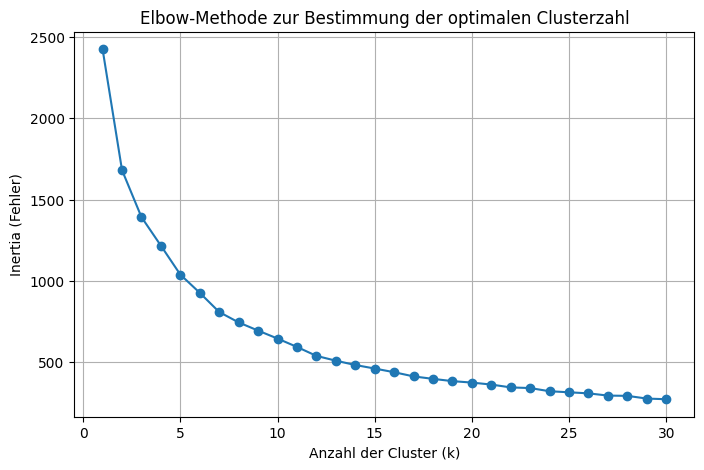

In [17]:
# Teste verschiedene Clusterzahlen (k = 1 bis 10)
inertia = []
k_values = range(1, 31)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_pollutants_scaled)
    inertia.append(kmeans.inertia_)  # Speichert den Fehler (Inertia)

# Elbow-Plot erstellen
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='-')
plt.xlabel("Anzahl der Cluster (k)")
plt.ylabel("Inertia (Fehler)")
plt.title("Elbow-Methode zur Bestimmung der optimalen Clusterzahl")
plt.grid(True);

In [18]:
# K-Means-Clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_pollutants_scaled["Cluster"] = kmeans.fit_predict(df_pollutants_scaled)
df_pollutants_scaled.head()

,Co,No2,O3,So2,Pm10,Pm25,Cluster
City,,,,,,,
Abu dhabi,-0.886235,0.274741,0.839516,0.013955,2.471636,1.410476,1
Adana,-0.213451,0.111655,-0.430305,-0.092252,0.021558,0.343637,2
Adapazarı,2.227586,0.361166,-0.442696,1.950809,0.357500,0.483186,3
Adelaide,-0.485953,1.629730,0.418736,0.488177,-0.908210,-1.513363,0
Aguascalientes,0.322763,0.940164,2.736334,0.000795,2.000689,1.720628,1


In [19]:
# Neue Cluster-Zuordnung der Städte anzeigen
pollutants_cluster_numbers = df_pollutants_scaled[["Cluster"]].sort_values(by="Cluster")
pollutants_cluster_numbers

,Cluster
City,
Nagoya,0
Saitama,0
Saint-étienne,0
Hiroshima,0
Saint-denis,0
...,...
Tabriz,3
Khorramshahr,3
Isfahan,3


In [20]:
cluster_counts = pollutants_cluster_numbers["Cluster"].value_counts().sort_index()
cluster_counts


Cluster
0    194
1     57
2    131
3     20
4      2
Name: count, dtype: int64

In [43]:
df_pollutants_with_cluster_numbers = pd.concat([df_pollutants, pollutants_cluster_numbers], axis=1)
df_pollutants_with_cluster_numbers.head()

,Co,No2,O3,So2,Pm10,Pm25,Cluster
City,,,,,,,
Abu dhabi,0.100047,12.196341,27.721309,4.985944,79.439340,97.846117,1
Adana,4.047877,11.253878,16.466835,4.181442,31.489910,68.214783,2
Adapazarı,18.371643,12.695786,16.357013,19.657261,38.064474,72.090748,3
Adelaide,2.448863,20.026720,23.991919,8.578091,13.293801,16.636843,0
Aguascalientes,7.194328,16.041774,44.532891,4.886259,70.222643,106.460538,1


In [25]:
df_pollutants_with_cluster_numbers.to_csv("df_pollutants.csv", index=True)  # Index speichern, damit die Städtenamen erhalten bleiben


In [ ]:
# DBSCAN als Test

# # Delhi wird bei 5 und 6 Clustern von KMeans als eigenes Cluster isoliert.
# # Test, ob DBSCAN eine andere Clusterbildung erzielt

# from sklearn.cluster import DBSCAN

# dbscan = DBSCAN(eps=3.5, min_samples=4)  # Parameter ggf. anpassen
# df_cluster["Cluster_DBSCAN"] = dbscan.fit_predict(df_scaled)

# df_cluster["Cluster_DBSCAN"].value_counts()

# df_cluster[df_cluster.index == "Delhi"]

Entscheidung: Tehran war schon rausgenommen, weil es ein eigenes Cluster bildet. Ohne Tehran bildet Delhi ein eigenes Cluster. Das lassen wir jetzt erst mal so.

## Zusammenführung Geodaten und Clusternummern

In [44]:
df_coords = df.set_index("City")[["Longitude", "Latitude"]]


In [45]:
df_coords.head()

,Longitude,Latitude
City,,
Graz,15.45000,47.06667
Innsbruck,11.39454,47.26266
Linz,14.28611,48.30639
Salzburg,13.04399,47.79941
Vienna,16.37208,48.20849


In [46]:
df_coords = df.groupby("City")[["Longitude", "Latitude"]].mean()
len(df_coords)

614

In [65]:
df_pollutants_with_cluster_numbers_and_geodata = df_pollutants_with_cluster_numbers.join(df_coords, how="left")
df_pollutants_with_cluster_numbers_and_geodata.head()

,Co,No2,O3,So2,Pm10,Pm25,Cluster,Longitude,Latitude
City,,,,,,,,,
Abu dhabi,0.100047,12.196341,27.721309,4.985944,79.439340,97.846117,1,54.39696,24.45118
Adana,4.047877,11.253878,16.466835,4.181442,31.489910,68.214783,2,35.32531,36.98615
Adapazarı,18.371643,12.695786,16.357013,19.657261,38.064474,72.090748,3,30.40333,40.78056
Adelaide,2.448863,20.026720,23.991919,8.578091,13.293801,16.636843,0,138.59863,-34.92866
Aguascalientes,7.194328,16.041774,44.532891,4.886259,70.222643,106.460538,1,-102.28259,21.88234


In [67]:
df_pollutants_with_cluster_numbers_and_geodata = df_pollutants_with_cluster_numbers_and_geodata.dropna(subset=["Longitude", "Latitude"])


In [68]:
len(df_pollutants_with_cluster_numbers_and_geodata)

403

## Cluster farbig plotten

In [69]:


import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt

# Weltkarte laden
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))

# Städte aus df_geodata in einen GeoDataFrame umwandeln
gdf_cities = gpd.GeoDataFrame(df_pollutants_with_cluster_numbers_and_geodata, 
                              geometry=gpd.points_from_xy(df_pollutants_with_cluster_numbers_and_geodata["Longitude"], df_pollutants_with_cluster_numbers_and_geodata["Latitude"]))


In [70]:
import matplotlib.colors as mcolors

# Eigene 5-Farben-Palette aus 'tab10' extrahieren
custom_cmap = mcolors.ListedColormap(plt.get_cmap("tab10").colors[:5])

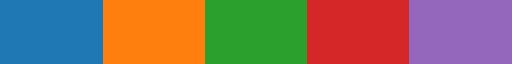

In [34]:
custom_cmap

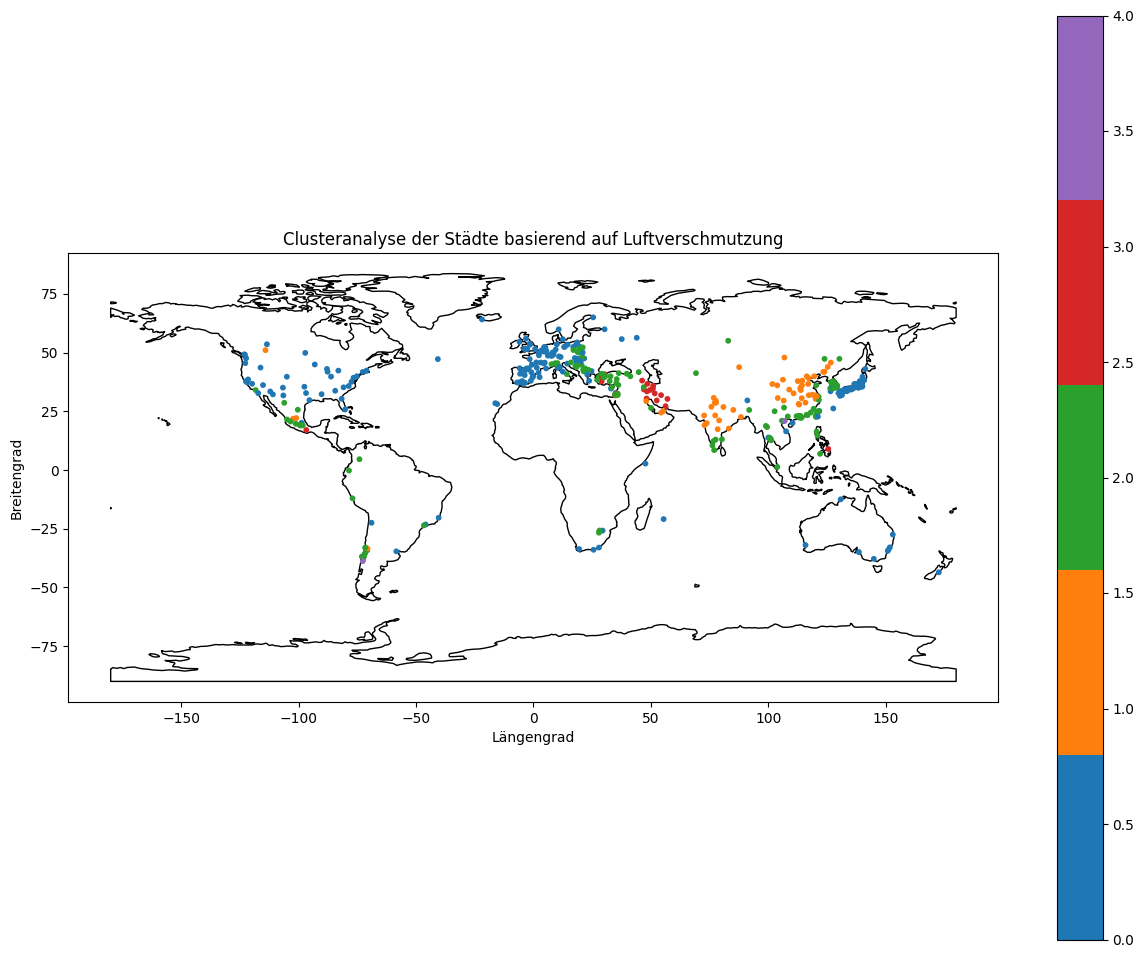

In [71]:
# Plot erstellen
fig, ax = plt.subplots(figsize=(15, 12))

# Umrisse der Weltkarte plotten
world.plot(ax=ax, color='white', edgecolor='black')

# Städte als farbige Punkte nach Cluster einfärben
scatter = gdf_cities.plot(column="Cluster", cmap=custom_cmap, ax=ax, markersize=10, legend=True, alpha=1.0)

# Titel & Achsen
plt.title("Clusteranalyse der Städte basierend auf Luftverschmutzung")
plt.xlabel("Längengrad")
plt.ylabel("Breitengrad")

plt.savefig("../Images/cluster_plot.png", dpi=300, bbox_inches="tight")

plt.show()



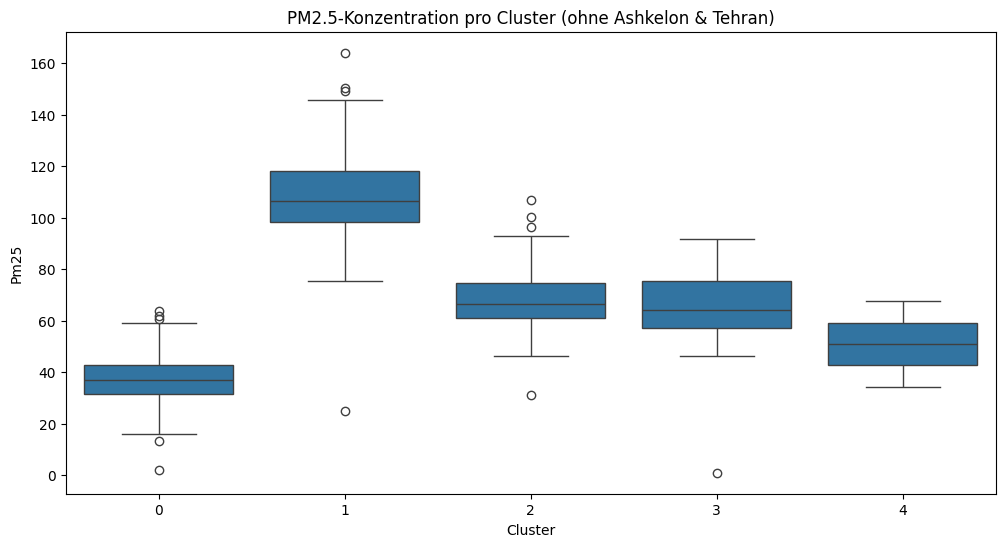

In [72]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Cluster", y="Pm25", data=df_pollutants_with_cluster_numbers_and_geodata)
plt.title("PM2.5-Konzentration pro Cluster (ohne Ashkelon & Tehran)")
plt.show()

In [73]:
outliers = []

for cluster in df_pollutants_with_cluster_numbers_and_geodata["Cluster"].unique():
    cluster_data = df_pollutants_with_cluster_numbers_and_geodata[df_pollutants_with_cluster_numbers_and_geodata["Cluster"] == cluster]
    
    Q1 = cluster_data["Pm25"].quantile(0.25)
    Q3 = cluster_data["Pm25"].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    cluster_outliers = cluster_data[(cluster_data["Pm25"] < lower_bound) | (cluster_data["Pm25"] > upper_bound)]
    
    outliers.append(cluster_outliers)

df_outliers = pd.concat(outliers)


In [55]:
df_outliers

,Co,No2,O3,So2,Pm10,Pm25,Cluster,Longitude,Latitude
City,,,,,,,,,
Calgary,3.051165,8.673767,0.100000,1.855900,99.500000,25.058465,1,-114.08529,51.05011
Delhi,9.360453,16.459586,9.186912,5.432543,130.130135,164.135800,1,77.23149,28.65195
Ghāziābād,10.016945,20.958153,11.167558,6.863813,117.044990,149.449660,1,77.43915,28.66535
Lucknow,9.352590,12.771519,13.164839,3.841549,93.851369,150.423991,1,80.92313,26.83928
Amman,18.969777,9.565977,13.517397,3.995421,29.047901,100.400000,2,35.94503,31.95522
Dammam,9.960784,2.452532,16.861769,1.890459,16.794508,106.813859,2,50.10326,26.43442
Sanandaj,10.965306,9.897814,21.083333,15.568479,45.336326,31.093713,2,46.99883,35.31495
Tashkent,6.020833,4.971186,0.100000,3.298544,38.095541,96.268707,2,69.21627,41.26465
Yazd,22.492213,33.807567,37.017621,24.727778,61.828548,0.877193,3,54.36750,31.89722


In [56]:
len(df_outliers)

14

## Untersuchung Cluster 4
Eventuell neue Clustereinteilung notwendig.

In [75]:
df_cluster_4 = df_pollutants_with_cluster_numbers_and_geodata.loc[["Hạ long", "Temuco"]]
df_cluster_4


,Co,No2,O3,So2,Pm10,Pm25,Cluster,Longitude,Latitude
City,,,,,,,,,
Hạ long,12.743137,8.007147,13.347468,85.921300,21.147486,34.310615,4,107.07336,20.95045
Temuco,5.967386,6.306072,1.466667,85.566667,33.212786,67.549576,4,-72.59842,-38.73965


In [77]:
cluster_means = df_pollutants_with_cluster_numbers_and_geodata.groupby("Cluster")[["Co", "No2", "O3", "So2", "Pm10", "Pm25"]].mean()
cluster_means


,Co,No2,O3,So2,Pm10,Pm25
Cluster,,,,,,
0,2.414796,7.768728,21.099413,2.280105,16.781451,37.222970
1,7.123085,14.150341,20.633470,6.224307,68.150699,108.414086
2,5.751516,11.545927,18.838284,5.016647,33.935189,68.149521
3,24.782001,22.367662,22.357309,17.387380,45.751786,64.003492
4,9.355262,7.156609,7.407067,85.743983,27.180136,50.930095


In [78]:
df_oaxaca = df_pollutants_with_cluster_numbers_and_geodata.loc["Oaxaca"]
df_oaxaca

Co           16.206810
No2          14.688882
O3           17.869819
So2          19.575223
Pm10         30.582082
Pm25         51.876404
Cluster       3.000000
Longitude   -96.723650
Latitude     17.065420
Name: Oaxaca, dtype: float64

## Interpretation der Cluster



In [57]:
cluster_summary = df_pollutants_with_cluster_numbers.groupby("Cluster").mean()
cluster_summary


,Co,No2,O3,So2,Pm10,Pm25
Cluster,,,,,,
0,2.410003,7.758433,21.069582,2.270174,16.762765,37.183960
1,7.123085,14.150341,20.633470,6.224307,68.150699,108.414086
2,5.751516,11.545927,18.838284,5.016647,33.935189,68.149521
3,24.782001,22.367662,22.357309,17.387380,45.751786,64.003492
4,9.355262,7.156609,7.407067,85.743983,27.180136,50.930095


In [58]:
# Städte in Cluster 0 anzeigen (Industrienationen mit Emissionsregulationen und wenig Schwerindustrie IN den Städten)
df_cluster_0 = df_pollutants_with_cluster_numbers[df_pollutants_with_cluster_numbers["Cluster"] == 0]

print(df_cluster_0.index.tolist())

['Adelaide', 'Akita', 'Albuquerque', 'Amiens', 'Amsterdam', 'Antwerpen', 'Athens', 'Atlanta', 'Augsburg', 'Baltimore', 'Barcelona', 'Belfast', 'Berlin', 'Bilbao', 'Boise', 'Bordeaux', 'Boston', 'Brisbane', 'Bristol', 'Brussels', 'Budapest', 'Buenos aires', 'Burgos', 'Bydgoszcz', 'Calama', 'Cardiff', 'Castelló de la plana', 'Charleroi', 'Charlotte', 'Chiba', 'Chicago', 'Christchurch', 'Clermont-ferrand', 'Copenhagen', 'Córdoba', 'Dallas', 'Darmstadt', 'Darwin', 'Debrecen', 'Denver', 'Detroit', 'Donostia / san sebastián', 'East london', 'Edinburgh', 'Edmonton', 'El paso', 'Florence', 'Fresno', 'Fukuoka', 'Gasteiz / vitoria', 'Gdańsk', 'Gent', 'Gifu-shi', 'Granada', 'Győr', 'Haarlem', 'Haifa', 'Haikou', 'Haiphong', 'Hamburg', 'Hamilton', 'Hartford', 'Hiroshima', 'Houston', 'Hsinchu', 'Huelva', 'Huế', 'Indianapolis', 'Jackson', 'Jacksonville', 'Jeju city', 'Kagoshima', 'Kanazawa', 'Karlsruhe', 'Kassel', 'Kecskemét', 'Keelung', 'Kobe', 'Kochi', 'Kumamoto', 'Kyoto', 'Las palmas de gran canar

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Cluster", y="Pm25", data=df_pollutants_with_cluster_numbers)

In [59]:
# Städte in Cluster 1 anzeigen (höchste Luftverschmutzung)
df_cluster_1 = df_pollutants_with_cluster_numbers[df_pollutants_with_cluster_numbers["Cluster"] == 1]

print(df_cluster_1.index.tolist())

['Abu dhabi', 'Aguascalientes', 'Anyang', 'Beijing', 'Bhopal', 'Calgary', 'Chandigarh', 'Changchun', 'Changsha', 'Changzhou', 'Chengdu', 'Chongqing', 'Delhi', 'Dubai', 'Fushun', 'Gandhinagar', 'Ghāziābād', 'Hangzhou', 'Harbin', 'Hefei', 'Hyderabad', 'Hāpur', 'Jaipur', 'Jinan', 'Kolkata', 'Lanzhou', 'Lucknow', 'Mumbai', 'Muzaffarnagar', 'Nagpur', 'Nanchang', 'Nanjing', 'Nashik', 'Patna', 'Petaẖ tiqwa', 'Qinhuangdao', 'San luis potosí', 'Santiago', 'Shenyang', 'Shijiazhuang', 'Shiyan', 'Suzhou', 'Taiyuan', 'Tianjin', 'Ulan bator', 'Visakhapatnam', 'Wuhan', 'Wuxi', 'Xining', 'Xinxiang', 'Xi’an', 'Xuchang', 'Yinchuan', 'Zhengzhou', 'Zhuzhou', 'Ürümqi', 'Ḩawallī']


In [60]:
# Städte in Cluster 2 anzeigen (Schwefeldioxid-Cluster; industrielle Emissionen, aber auch Vulkanaktivität)
df_cluster_2 = df_pollutants_with_cluster_numbers[df_pollutants_with_cluster_numbers["Cluster"] == 2]

print(df_cluster_2.index.tolist())

['Adana', 'Amman', 'Andong', 'Ankara', 'Antakya', 'Baguio', 'Balıkesir', 'Bangkok', 'Belgrade', 'Bengaluru', 'Bogotá', 'Brescia', 'Busan', 'Changwon', 'Chennai', 'Cheongju-si', 'Chiang mai', 'Chihuahua', 'Chillán', 'Chon buri', 'Chuncheon', 'Concepción', 'Cuernavaca', 'Daegu', 'Daejeon', 'Dammam', 'Dongguan', 'Douliu', 'Erzurum', 'Eskişehir', 'Foshan', 'Fuzhou', 'Guadalajara', 'Guangzhou', 'Guiyang', 'Gwangju', 'Hanoi', 'Hegang', 'Hong kong', 'Incheon', 'Irbid', 'Istanbul', 'İzmir', 'İzmit', 'Jeonju', 'Jerusalem', 'Jieyang', 'Johannesburg', 'Kaohsiung', 'Katowice', 'Kayseri', 'Kielce', 'Konya', 'Kraków', 'Kunming', 'Kütahya', 'Lampang', 'Lima', 'Los angeles', 'Los ángeles', 'Macau', 'Manila', 'Mexico city', 'Milan', 'Miskolc', 'Mokpo', 'Monterrey', 'Morelia', 'Mysore', 'Nanning', 'Naples', 'Nicosia', 'Ningbo', 'Niš', 'Novi sad', 'Novosibirsk', 'Parma', 'Pohang', 'Pretoria', 'Pristina', 'Puebla', 'Qingdao', 'Qiqihar', 'Quilpué', 'Quito', 'Rancagua', 'Rayong', 'Samsun', 'Samut prakan',

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Cluster", y="So2", data=df_pollutants_with_cluster_numbers)
plt.title("SO₂-Konzentration pro Cluster")
plt.show()

In [61]:
# Städte in Cluster 3 anzeigen (mittlere Luftverschmutzung mit Ausreißern)
df_cluster_3 = df_pollutants_with_cluster_numbers[df_pollutants_with_cluster_numbers["Cluster"] == 3]

print(df_cluster_3.index.tolist())

['Adapazarı', 'Arāk', 'Ashdod', 'Bandar abbas', 'Bursa', 'Butuan', 'Denizli', 'Isfahan', 'Karaj', 'Kerman', 'Kermanshah', 'Khorramabad', 'Khorramshahr', 'Netanya', 'Oaxaca', 'Qom', 'Shiraz', 'Tabriz', 'Yazd', 'Zanjān']


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(x="Cluster", y="No2", data=df_pollutants_with_cluster_numbers)
plt.title("PM2.5-Konzentration pro Cluster")
plt.show()

In [62]:
# Städte in Cluster 4 anzeigen (Ashkelon, ungewöhnlich hoher CO-Wert)
df_cluster_4 = df_pollutants_with_cluster_numbers[df_pollutants_with_cluster_numbers["Cluster"] == 4]

print(df_cluster_4.index.tolist())

['Hạ long', 'Temuco']


In [ ]:
ashkelon_values = df_pollutants_with_cluster_numbers.loc["Ashkelon"]
ashkelon_values

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Cluster", y="Co", data=df_pollutants_with_cluster_numbers)
plt.title("CO-Konzentration pro Cluster")
plt.show()

## Ergebnis Clustering

    Cluster 0 → Saubere Städte mit niedriger Luftverschmutzung
    Cluster 1 → Höchstverschmutzte Städte mit extremen PM2.5-Werten
    Cluster 2 → Städte mit moderater bis hoher Luftverschmutzung
    Cluster 3 → Industrie- & SO₂-Städte mit moderaten Werten
    Cluster 4 → Schwefeldioxid-Sondergruppe (Hạ Long & Temuco) mit extrem hohen SO₂-Werten